In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Deform a source mesh to form a target mesh using 3D loss functions 有用


在本教程中，我们将学习如何将一个初始通用形状（如球体）变形以适配目标形状。

主要内容包括：

- 如何从`.obj`文件**加载网格**
- 如何使用PyTorch3D的**Meshes数据结构**
- 如何使用4种不同的PyTorch3D**网格损失函数**
- 如何建立**优化循环**

我们从球体网格出发，通过逐步优化学习网格中各顶点的偏移量，使预测网格在每一步都更接近目标形态。为此需要最小化以下指标：

+ `倒角距离(chamfer_distance)`：即预测（变形后）网格与目标网格之间的距离，定义为两者表面经**可微分采样点集**之间的倒角距离。

但仅最小化预测与目标间的倒角距离会导致形状不平滑（可通过设置`w_chamfer=1.0`并将其他权重设为`0.0`验证）。

我们通过添加以下**形状正则项**来保证平滑性：
+ `mesh_edge_length`：最小化预测网格中的边长
+ `mesh_normal_consistency`：强制相邻面法向量的一致性
+ `mesh_laplacian_smoothing`：拉普拉斯平滑正则项

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#     version_str="".join([
#         f"py3{sys.version_info.minor}_cu",
#         torch.version.cuda.replace(".",""),
#         f"_pyt{pyt_version_str}"
#     ])
#     !pip install iopath
#     if sys.platform.startswith("linux"):
#         print("Trying to install wheel for PyTorch3D")
#         !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#         pip_list = !pip freeze
#         need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
#     if need_pytorch3d:
#         print(f"failed to find/install wheel for {version_str}")
# if need_pytorch3d:
#     print("Installing PyTorch3D from source")
#     !pip install ninja
#     !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:5")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [4]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2025-03-31 14:13:48--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Connecting to 172.40.1.136:7890... connected.
Proxy request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.1’

dolphin.obj.1       100%[===================>] 153.09K   266KB/s    in 0.6s    

2025-03-31 14:13:50 (266 KB/s) - ‘dolphin.obj.1’ saved [156763/156763]



In [5]:
# Load the dolphin mesh.
trg_obj = './data/modified_white_yellow_mug.obj'

In [6]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

/data1/daiyukun/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [7]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/data1/daiyukun/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/structures/meshes.py:1097: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


## 2. Visualize the source and target meshes

In [8]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [9]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Optimization loop 

In [10]:
# 我们将学习通过偏移顶点来变形源网格
# 变形参数的形状等于src_mesh中的顶点总数"

# （注：根据技术文档翻译规范，保留术语"src_mesh"不译以保持准确性；调整了句式结构使其更符合中文表达习惯；使用专业术语"偏移顶点/变形参数"确保技术含义准确传达）
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [11]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

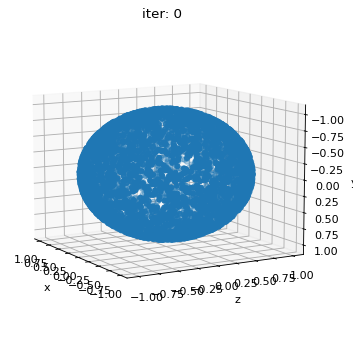

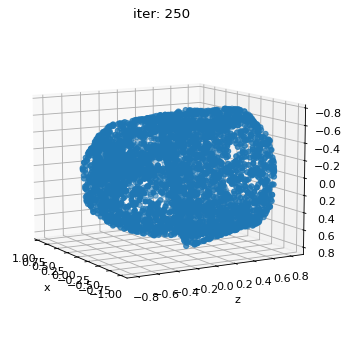

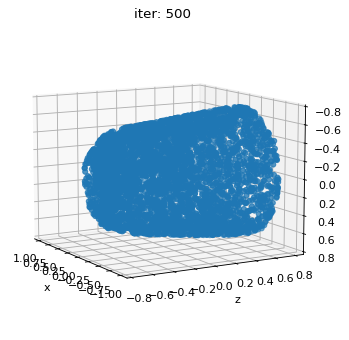

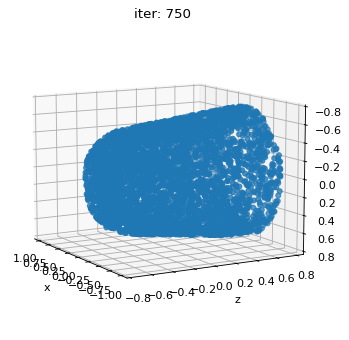

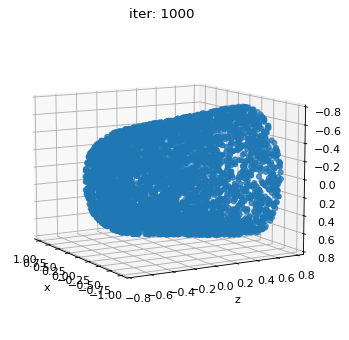

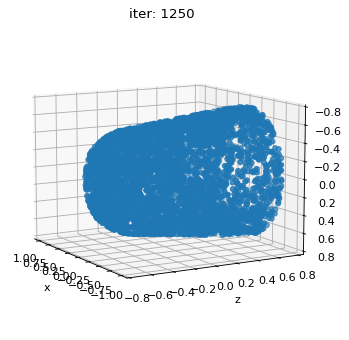

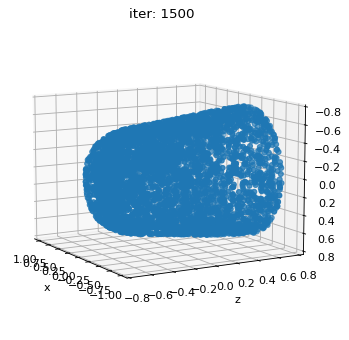

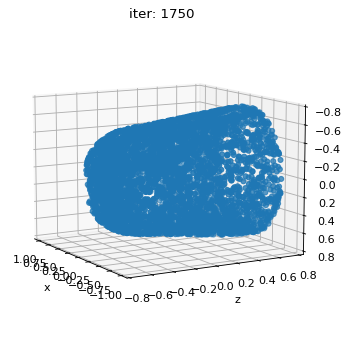

In [12]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()


## 4. Visualize the loss

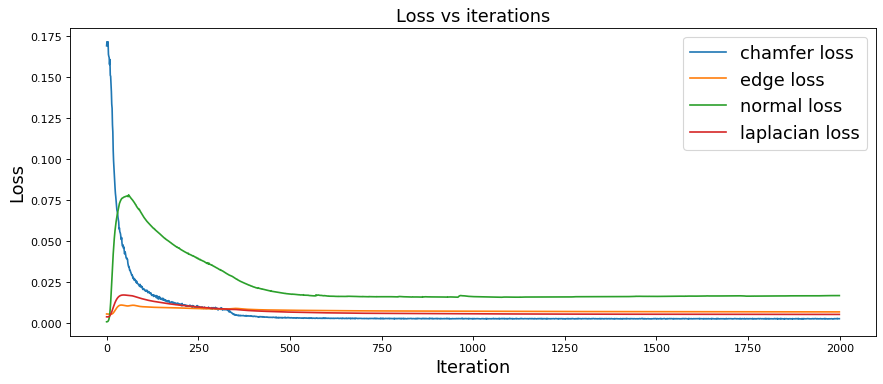

In [13]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

## 5. Save the predicted mesh

In [14]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)

## 6. Conclusion 

In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3D mesh loss functions. 